<a href="https://colab.research.google.com/github/stahelin/puc_dl2cv/blob/main/predrnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1 - Instalando todas as dependencias do OpenSTL (Mesmo que redundantes, por garantia) e montando o Drive
*Reinicie o ambiente de execução antes de prosseguir para utilizar as versões mais recentes instaladas


In [1]:
!git clone https://github.com/chengtan9907/OpenSTL

Cloning into 'OpenSTL'...
remote: Enumerating objects: 2259, done.
remote: Counting objects: 100% (763/763), done.
remote: Compressing objects: 100% (189/189), done.
remote: Total 2259 (delta 657), reused 592 (delta 574), pack-reused 1496
Receiving objects: 100% (2259/2259), 2.13 MiB | 7.99 MiB/s, done.
Resolving deltas: 100% (1650/1650), done.


In [ ]:
import os
!pip install fvcore
!pip install -e OpenSTL
os.chdir('/content/OpenSTL')

In [ ]:
!pip install argparse
!pip install dask
!pip install decord
!pip install git+https://github.com/facebookresearch/fvcore.git
!pip install hickle
!pip install lpips
!pip install matplotlib
!pip install netCDF4
!pip install numpy
!pip install opencv-python
!pip install packaging
!pip install pandas
!pip install scikit-image
!pip install scikit-learn
!pip install torch
!pip install timm
!pip install tqdm
!pip install xarray==0.19.0

In [5]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


#2 - Carregando bibliotecas

In [3]:
import pickle
import cv2
import numpy as np
import numpy as np
import torch
import os
from torch.utils.data import Dataset
from openstl.utils import show_video_line
from openstl.api import BaseExperiment
from openstl.utils import create_parser, default_parser

#3 - Pré-processamento dos vídeos (redimensionamento, armazenamento dos frames em pkl)

In [4]:
batch_size = 1
pre_seq_length = 10
aft_seq_length = 20

def sample_frames(video_path, num_frames=20):
    height = 224
    width = 224
    # Lê o vídeo
    video = cv2.VideoCapture(video_path)
    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    # Amostra uniformemente quadros do vídeo
    frame_idxs = np.linspace(0, total_frames-1, num_frames, dtype=int)
    frames = []
    for idx in frame_idxs:
        video.set(cv2.CAP_PROP_POS_FRAMES, idx)
        _, frame = video.read()
        frame = cv2.resize(frame, (height, width))
        frames.append(frame)
    video.release()
    return np.stack(frames)

def process_folder(folder_path, pre_slen=10, aft_slen=10, suffix='.avi'):
    # Obtém todos os vídeos nesta pasta
    videos = []
    files = os.listdir(folder_path)
    for file in files:
        video_path = os.path.join(folder_path, file)
        if os.path.isfile(video_path) and file.endswith(suffix):
            video = sample_frames(video_path, pre_slen + aft_slen)
            videos.append(video)
    # Empilha quadros de vídeo de cada pasta
    data = np.stack(videos).transpose(0, 1, 4, 2, 3)

    # se os dados estão em [0, 255], reescala para [0, 1]
    if data.max() > 1.0:
        data = data.astype(np.float32) / 255.0

    return data[:, :pre_slen], data[:, pre_slen:]

# Caminho base para as pastas de dados no Google Drive
base_path = '/content/drive/MyDrive/Doutorado/DL2CV/Trabalho/video_dataset'

dataset = {}
folders = ['train', 'val', 'test']
for folder in folders:
    folder_path = os.path.join(base_path, folder)
    data_x, data_y = process_folder(folder_path, pre_slen=pre_seq_length, aft_slen=aft_seq_length, suffix='.avi')
    dataset['X_' + folder], dataset['Y_' + folder] = data_x, data_y

# Salva como um arquivo pkl
with open('/content/drive/MyDrive/Doutorado/DL2CV/Trabalho/dataset_224.pkl', 'wb') as f:
    pickle.dump(dataset, f)

# Carregando dados

with open('/content/drive/MyDrive/Doutorado/DL2CV/Trabalho/dataset_224.pkl', 'rb') as f:
    dataset = pickle.load(f)

train_x, train_y = dataset['X_train'], dataset['Y_train']
print(train_x.shape)



(7, 10, 3, 224, 224)


#4 - PredRNN - Configurações de treinamento

In [15]:
custom_training_config = {
    'pre_seq_length': pre_seq_length,
    'aft_seq_length': aft_seq_length,
    'total_length': pre_seq_length + aft_seq_length,
    'batch_size': batch_size,
    'val_batch_size': batch_size,
    'epoch': 50,
    'lr': 0.001,
    'metrics': ['mse', 'mae', "rmse"],
    'ex_name': 'pred_rnn',
    'dataname': 'custom',
    'in_shape': [10, 3, 224, 224],
}

custom_model_config = {
    "method": 'PredRNN',
    "reverse_scheduled_sampling": 0,
    "r_sampling_step_1": 25000,
    "r_sampling_step_2": 50000,
    "r_exp_alpha": 5000,
    "scheduled_sampling": 1,
    "sampling_stop_iter": 50000,
    "sampling_start_value": 1.0,
    "sampling_changing_rate": 0.00002,
    "num_hidden": '128,128,128,128',
    "filter_size": 5,
    "stride": 1,
    "patch_size": 2,
    "layer_norm": 0
}

#5 - Dataloader

In [16]:
class CustomDataset(Dataset):
    def __init__(self, X, Y, normalize=False):
        super(CustomDataset, self).__init__()
        self.X = X
        self.Y = Y
        self.mean = None
        self.std = None

        if normalize:
            # get the mean/std values along the channel dimension
            mean = data.mean(axis=(0, 1, 2, 3)).reshape(1, 1, -1, 1, 1)
            std = data.std(axis=(0, 1, 2, 3)).reshape(1, 1, -1, 1, 1)
            data = (data - mean) / std
            self.mean = mean
            self.std = std

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, index):
        data = torch.tensor(self.X[index]).float()
        labels = torch.tensor(self.Y[index]).float()
        return data, labels


X_train, X_val, X_test, Y_train, Y_val, Y_test = dataset['X_train'], dataset[
    'X_val'], dataset['X_test'], dataset['Y_train'], dataset['Y_val'], dataset['Y_test']

train_set = CustomDataset(X=X_train, Y=Y_train)
val_set = CustomDataset(X=X_val, Y=Y_val)
test_set = CustomDataset(X=X_test, Y=Y_test)

dataloader_train = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True, pin_memory=True)
dataloader_val = torch.utils.data.DataLoader(
    val_set, batch_size=batch_size, shuffle=True, pin_memory=True)
dataloader_test = torch.utils.data.DataLoader(
    test_set, batch_size=batch_size, shuffle=True, pin_memory=True)

#6 - Configurações experimentais

In [17]:
args = create_parser().parse_args([])
config = args.__dict__

# Atualiza a configuração de treinamento
config.update(custom_training_config)
# Atualiza a configuração do modelo
config.update(custom_model_config)
# Preenche com valores padrão
default_values = default_parser()
for attribute in default_values.keys():
    if config[attribute] is None:
        config[attribute] = default_values[attribute]

exp = BaseExperiment(args, dataloaders=(dataloader_train, dataloader_val, dataloader_test))


Use non-distributed mode with GPU: cuda:0
Environment info:
------------------------------------------------------------
sys.platform: linux
Python: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
CUDA available: True
CUDA_HOME: /usr/local/cuda
NVCC: Build cuda_11.8.r11.8/compiler.31833905_0
GPU 0: NVIDIA A100-SXM4-40GB
GCC: gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
PyTorch: 2.1.0+cu118
PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2022.2-Product Build 20220804 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.1.1 (Git Hash 64f6bcbcbab628e96f33a62c3e975f8535a7bde4)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX512
  - CUDA Runtime 11.8
  - NVCC architecture flags: -gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_70,code=sm_70;-gencode;arch=compute_75

In [18]:
import contextlib
with open('training_output.txt', 'w') as f:
    with contextlib.redirect_stdout(f):
        exp.train()
        exp.test()


train loss: 0.1736 | data time: 0.0053: 100%|██████████| 7/7 [00:04<00:00,  1.47it/s]

[                                                  ] 0/7, elapsed: 0s, ETA:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 4.1 task/s, elapsed: 2s, ETA:     0s[2023-12-12 12:14:04] Intermediate result: 24409.795  (Index 10)


train loss: 0.0428 | data time: 0.0053: 100%|██████████| 7/7 [00:04<00:00,  1.48it/s]

[                                                  ] 0/7, elapsed: 0s, ETA:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 4.1 task/s, elapsed: 2s, ETA:     0s[2023-12-12 12:14:12] Intermediate result: 2857.7554  (Index 11)


train loss: 0.0131 | data time: 0.0054: 100%|██████████| 7/7 [00:04<00:00,  1.48it/s]

[                                                  ] 0/7, elapsed: 0s, ETA:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 4.1 task/s, elapsed: 2s, ETA:     0s[2023-12-12 12:14:19] Intermediate result: 1252.0911  (Index 12)


train loss: 0.0071 | data time: 0.0055: 100%|██████████| 7/7 [00:04<00:00,  1.47it/s]

[                                                  ] 0/7, elapsed: 0s, ETA:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 4.1 task/s, elapsed: 2s, ETA:     0s[2023-12-12 12:14:26] Intermediate result: 923.87946  (Index 13)


train loss: 0.0070 | data time: 0.0051: 100%|██████████| 7/7 [00:04<00:00,  1.48it/s]

[                                                  ] 0/7, elapsed: 0s, ETA:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 4.1 task/s, elapsed: 2s, ETA:     0s[2023-12-12 12:14:33] Intermediate result: 599.1474  (Index 14)


train loss: 0.0045 | data time: 0.0051: 100%|██████████| 7/7 [00:04<00:00,  1.48it/s]

[                                                  ] 0/7, elapsed: 0s, ETA:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 4.1 task/s, elapsed: 2s, ETA:     0s[2023-12-12 12:14:40] Intermediate result: 422.13916  (Index 15)


train loss: 0.0034 | data time: 0.0046: 100%|██████████| 7/7 [00:04<00:00,  1.48it/s]

[                                                  ] 0/7, elapsed: 0s, ETA:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 4.1 task/s, elapsed: 2s, ETA:     0s[2023-12-12 12:14:47] Intermediate result: 340.24612  (Index 16)


train loss: 0.0029 | data time: 0.0054: 100%|██████████| 7/7 [00:04<00:00,  1.47it/s]

[                                                  ] 0/7, elapsed: 0s, ETA:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 4.1 task/s, elapsed: 2s, ETA:     0s[2023-12-12 12:14:54] Intermediate result: 635.2402  (Index 17)


train loss: 0.0027 | data time: 0.0052: 100%|██████████| 7/7 [00:04<00:00,  1.48it/s]

[                                                  ] 0/7, elapsed: 0s, ETA:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 4.1 task/s, elapsed: 2s, ETA:     0s[2023-12-12 12:15:01] Intermediate result: 517.35675  (Index 18)


train loss: 0.0023 | data time: 0.0052: 100%|██████████| 7/7 [00:04<00:00,  1.47it/s]

[                                                  ] 0/7, elapsed: 0s, ETA:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 4.1 task/s, elapsed: 2s, ETA:     0s[2023-12-12 12:15:08] Intermediate result: 542.57684  (Index 19)


train loss: 0.0021 | data time: 0.0082: 100%|██████████| 7/7 [00:04<00:00,  1.47it/s]

[                                                  ] 0/7, elapsed: 0s, ETA:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 4.1 task/s, elapsed: 2s, ETA:     0s[2023-12-12 12:15:15] Intermediate result: 810.0739  (Index 20)


train loss: 0.0020 | data time: 0.0051: 100%|██████████| 7/7 [00:04<00:00,  1.48it/s]

[                                                  ] 0/7, elapsed: 0s, ETA:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 4.1 task/s, elapsed: 2s, ETA:     0s[2023-12-12 12:15:22] Intermediate result: 1119.4055  (Index 21)


train loss: 0.0012 | data time: 0.0053: 100%|██████████| 7/7 [00:04<00:00,  1.47it/s]

[                                                  ] 0/7, elapsed: 0s, ETA:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 4.1 task/s, elapsed: 2s, ETA:     0s[2023-12-12 12:15:29] Intermediate result: 276.03214  (Index 22)


train loss: 0.0013 | data time: 0.0049: 100%|██████████| 7/7 [00:04<00:00,  1.48it/s]

[                                                  ] 0/7, elapsed: 0s, ETA:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 4.1 task/s, elapsed: 2s, ETA:     0s[2023-12-12 12:15:36] Intermediate result: 254.40517  (Index 23)


train loss: 0.0014 | data time: 0.0054: 100%|██████████| 7/7 [00:04<00:00,  1.48it/s]

[                                                  ] 0/7, elapsed: 0s, ETA:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 4.1 task/s, elapsed: 2s, ETA:     0s[2023-12-12 12:15:44] Intermediate result: 391.56735  (Index 24)


train loss: 0.0011 | data time: 0.0056: 100%|██████████| 7/7 [00:04<00:00,  1.47it/s]

[                                                  ] 0/7, elapsed: 0s, ETA:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 4.1 task/s, elapsed: 2s, ETA:     0s[2023-12-12 12:15:50] Intermediate result: 219.43503  (Index 25)


train loss: 0.0014 | data time: 0.0051: 100%|██████████| 7/7 [00:04<00:00,  1.48it/s]

[                                                  ] 0/7, elapsed: 0s, ETA:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 4.1 task/s, elapsed: 2s, ETA:     0s[2023-12-12 12:15:58] Intermediate result: 199.36983  (Index 26)


train loss: 0.0011 | data time: 0.0055: 100%|██████████| 7/7 [00:04<00:00,  1.47it/s]

[                                                  ] 0/7, elapsed: 0s, ETA:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 4.1 task/s, elapsed: 2s, ETA:     0s[2023-12-12 12:16:05] Intermediate result: 183.0634  (Index 27)


train loss: 0.0009 | data time: 0.0047: 100%|██████████| 7/7 [00:04<00:00,  1.48it/s]

[                                                  ] 0/7, elapsed: 0s, ETA:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 4.1 task/s, elapsed: 2s, ETA:     0s[2023-12-12 12:16:12] Intermediate result: 256.0231  (Index 28)


train loss: 0.0009 | data time: 0.0049: 100%|██████████| 7/7 [00:04<00:00,  1.48it/s]

[                                                  ] 0/7, elapsed: 0s, ETA:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 4.1 task/s, elapsed: 2s, ETA:     0s[2023-12-12 12:16:19] Intermediate result: 202.2435  (Index 29)


train loss: 0.0013 | data time: 0.0051: 100%|██████████| 7/7 [00:04<00:00,  1.48it/s]

[                                                  ] 0/7, elapsed: 0s, ETA:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 4.1 task/s, elapsed: 2s, ETA:     0s[2023-12-12 12:16:26] Intermediate result: 1549.6992  (Index 30)


train loss: 0.0011 | data time: 0.0052: 100%|██████████| 7/7 [00:04<00:00,  1.47it/s]

[                                                  ] 0/7, elapsed: 0s, ETA:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 4.1 task/s, elapsed: 2s, ETA:     0s[2023-12-12 12:16:33] Intermediate result: 201.03435  (Index 31)


train loss: 0.0007 | data time: 0.0050: 100%|██████████| 7/7 [00:04<00:00,  1.48it/s]

[                                                  ] 0/7, elapsed: 0s, ETA:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 4.1 task/s, elapsed: 2s, ETA:     0s[2023-12-12 12:16:40] Intermediate result: 169.13611  (Index 32)


train loss: 0.0007 | data time: 0.0051: 100%|██████████| 7/7 [00:04<00:00,  1.48it/s]

[                                                  ] 0/7, elapsed: 0s, ETA:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 4.1 task/s, elapsed: 2s, ETA:     0s[2023-12-12 12:16:47] Intermediate result: 515.7966  (Index 33)


train loss: 0.0006 | data time: 0.0053: 100%|██████████| 7/7 [00:04<00:00,  1.48it/s]

[                                                  ] 0/7, elapsed: 0s, ETA:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 4.1 task/s, elapsed: 2s, ETA:     0s[2023-12-12 12:16:54] Intermediate result: 247.46054  (Index 34)


train loss: 0.0009 | data time: 0.0049: 100%|██████████| 7/7 [00:04<00:00,  1.48it/s]

[                                                  ] 0/7, elapsed: 0s, ETA:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 4.1 task/s, elapsed: 2s, ETA:     0s[2023-12-12 12:17:01] Intermediate result: 259.00705  (Index 35)


train loss: 0.0006 | data time: 0.0051: 100%|██████████| 7/7 [00:04<00:00,  1.48it/s]

[                                                  ] 0/7, elapsed: 0s, ETA:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 4.1 task/s, elapsed: 2s, ETA:     0s[2023-12-12 12:17:08] Intermediate result: 169.29471  (Index 36)


train loss: 0.0007 | data time: 0.0052: 100%|██████████| 7/7 [00:04<00:00,  1.47it/s]

[                                                  ] 0/7, elapsed: 0s, ETA:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 4.1 task/s, elapsed: 2s, ETA:     0s[2023-12-12 12:17:15] Intermediate result: 221.66338  (Index 37)


train loss: 0.0005 | data time: 0.0049: 100%|██████████| 7/7 [00:04<00:00,  1.48it/s]

[                                                  ] 0/7, elapsed: 0s, ETA:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 4.1 task/s, elapsed: 2s, ETA:     0s[2023-12-12 12:17:22] Intermediate result: 201.38628  (Index 38)


train loss: 0.0006 | data time: 0.0053: 100%|██████████| 7/7 [00:04<00:00,  1.47it/s]

[                                                  ] 0/7, elapsed: 0s, ETA:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 4.1 task/s, elapsed: 2s, ETA:     0s[2023-12-12 12:17:29] Intermediate result: 146.73196  (Index 39)


train loss: 0.0006 | data time: 0.0049: 100%|██████████| 7/7 [00:04<00:00,  1.47it/s]

[                                                  ] 0/7, elapsed: 0s, ETA:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 4.1 task/s, elapsed: 2s, ETA:     0s[2023-12-12 12:17:36] Intermediate result: 272.86356  (Index 40)


train loss: 0.0007 | data time: 0.0053: 100%|██████████| 7/7 [00:04<00:00,  1.47it/s]

[                                                  ] 0/7, elapsed: 0s, ETA:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 4.1 task/s, elapsed: 2s, ETA:     0s[2023-12-12 12:17:43] Intermediate result: 120.74742  (Index 41)


train loss: 0.0006 | data time: 0.0054: 100%|██████████| 7/7 [00:04<00:00,  1.47it/s]

[                                                  ] 0/7, elapsed: 0s, ETA:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 4.1 task/s, elapsed: 2s, ETA:     0s[2023-12-12 12:17:50] Intermediate result: 121.90509  (Index 42)


train loss: 0.0005 | data time: 0.0054: 100%|██████████| 7/7 [00:04<00:00,  1.47it/s]

[                                                  ] 0/7, elapsed: 0s, ETA:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 4.1 task/s, elapsed: 2s, ETA:     0s[2023-12-12 12:17:57] Intermediate result: 129.07045  (Index 43)


train loss: 0.0007 | data time: 0.0050: 100%|██████████| 7/7 [00:04<00:00,  1.48it/s]

[                                                  ] 0/7, elapsed: 0s, ETA:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 4.1 task/s, elapsed: 2s, ETA:     0s[2023-12-12 12:18:04] Intermediate result: 129.16878  (Index 44)


train loss: 0.0005 | data time: 0.0053: 100%|██████████| 7/7 [00:04<00:00,  1.47it/s]

[                                                  ] 0/7, elapsed: 0s, ETA:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 4.1 task/s, elapsed: 2s, ETA:     0s[2023-12-12 12:18:11] Intermediate result: 110.53622  (Index 45)


train loss: 0.0005 | data time: 0.0053: 100%|██████████| 7/7 [00:04<00:00,  1.48it/s]

[                                                  ] 0/7, elapsed: 0s, ETA:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 4.1 task/s, elapsed: 2s, ETA:     0s[2023-12-12 12:18:18] Intermediate result: 136.48958  (Index 46)


train loss: 0.0005 | data time: 0.0053: 100%|██████████| 7/7 [00:04<00:00,  1.47it/s]

[                                                  ] 0/7, elapsed: 0s, ETA:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 4.1 task/s, elapsed: 2s, ETA:     0s[2023-12-12 12:18:25] Intermediate result: 105.45393  (Index 47)


train loss: 0.0007 | data time: 0.0051: 100%|██████████| 7/7 [00:04<00:00,  1.48it/s]

[                                                  ] 0/7, elapsed: 0s, ETA:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 4.1 task/s, elapsed: 2s, ETA:     0s[2023-12-12 12:18:32] Intermediate result: 117.19061  (Index 48)


train loss: 0.0005 | data time: 0.0050: 100%|██████████| 7/7 [00:04<00:00,  1.47it/s]

[                                                  ] 0/7, elapsed: 0s, ETA:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 4.1 task/s, elapsed: 2s, ETA:     0s[2023-12-12 12:18:39] Intermediate result: 107.12264  (Index 49)


train loss: 0.0006 | data time: 0.0051: 100%|██████████| 7/7 [00:04<00:00,  1.47it/s]

[                                                  ] 0/7, elapsed: 0s, ETA:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 4.1 task/s, elapsed: 2s, ETA:     0s[2023-12-12 12:18:46] Intermediate result: 111.467995  (Index 50)


train loss: 0.0004 | data time: 0.0049: 100%|██████████| 7/7 [00:04<00:00,  1.48it/s]

[                                                  ] 0/7, elapsed: 0s, ETA:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 4.1 task/s, elapsed: 2s, ETA:     0s[2023-12-12 12:18:53] Intermediate result: 101.42432  (Index 51)


train loss: 0.0005 | data time: 0.0057: 100%|██████████| 7/7 [00:04<00:00,  1.47it/s]

[                                                  ] 0/7, elapsed: 0s, ETA:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 4.1 task/s, elapsed: 2s, ETA:     0s[2023-12-12 12:19:00] Intermediate result: 100.057175  (Index 52)


train loss: 0.0008 | data time: 0.0051: 100%|██████████| 7/7 [00:04<00:00,  1.47it/s]

[                                                  ] 0/7, elapsed: 0s, ETA:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 4.1 task/s, elapsed: 2s, ETA:     0s[2023-12-12 12:19:07] Intermediate result: 100.92779  (Index 53)


train loss: 0.0004 | data time: 0.0055: 100%|██████████| 7/7 [00:04<00:00,  1.47it/s]

[                                                  ] 0/7, elapsed: 0s, ETA:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 4.1 task/s, elapsed: 2s, ETA:     0s[2023-12-12 12:19:14] Intermediate result: 98.49207  (Index 54)


train loss: 0.0008 | data time: 0.0051: 100%|██████████| 7/7 [00:04<00:00,  1.47it/s]

[                                                  ] 0/7, elapsed: 0s, ETA:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 4.1 task/s, elapsed: 2s, ETA:     0s[2023-12-12 12:19:22] Intermediate result: 97.626366  (Index 55)


train loss: 0.0005 | data time: 0.0054: 100%|██████████| 7/7 [00:04<00:00,  1.47it/s]

[                                                  ] 0/7, elapsed: 0s, ETA:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 4.1 task/s, elapsed: 2s, ETA:     0s[2023-12-12 12:19:29] Intermediate result: 98.419174  (Index 56)


train loss: 0.0008 | data time: 0.0050: 100%|██████████| 7/7 [00:04<00:00,  1.47it/s]

[                                                  ] 0/7, elapsed: 0s, ETA:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 4.1 task/s, elapsed: 2s, ETA:     0s[2023-12-12 12:19:36] Intermediate result: 98.74981  (Index 57)


train loss: 0.0007 | data time: 0.0054: 100%|██████████| 7/7 [00:04<00:00,  1.47it/s]

[                                                  ] 0/7, elapsed: 0s, ETA:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 4.1 task/s, elapsed: 2s, ETA:     0s[2023-12-12 12:19:43] Intermediate result: 98.327644  (Index 58)


train loss: 0.0006 | data time: 0.0052: 100%|██████████| 7/7 [00:04<00:00,  1.47it/s]

[                                                  ] 0/7, elapsed: 0s, ETA:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 4.1 task/s, elapsed: 2s, ETA:     0s[2023-12-12 12:19:50] Intermediate result: 98.314064  (Index 59)
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 4.5 task/s, elapsed: 2s, ETA:     0s

#7 - Resultados

In [19]:
import re

def process_log_file(filename):
    with open(filename, 'r') as file:
        lines = file.readlines()

    train_losses = []
    val_losses = []
    val_mse = []
    val_mae = []

    for line in lines:
        # Encontrar e armazenar a perda de treinamento
        train_match = re.search(r'Train Loss: ([0-9\.]+)', line)
        if train_match:
            train_losses.append(float(train_match.group(1)))

        # Encontrar e armazenar a perda de validação
        val_match = re.search(r'Vali Loss: ([0-9\.]+)', line)
        if val_match:
            val_losses.append(float(val_match.group(1)))

        # Exemplo para capturar MSE e MAE da validação
        mse_match = re.search(r'mse:([0-9\.]+)', line)
        if mse_match:
            val_mse.append(float(mse_match.group(1)))

        mae_match = re.search(r'mae:([0-9\.]+)', line)
        if mae_match:
            val_mae.append(float(mae_match.group(1)))

    return train_losses, val_losses, val_mse, val_mae

train_losses, val_losses, val_mse, val_mae = process_log_file('training_output.txt')


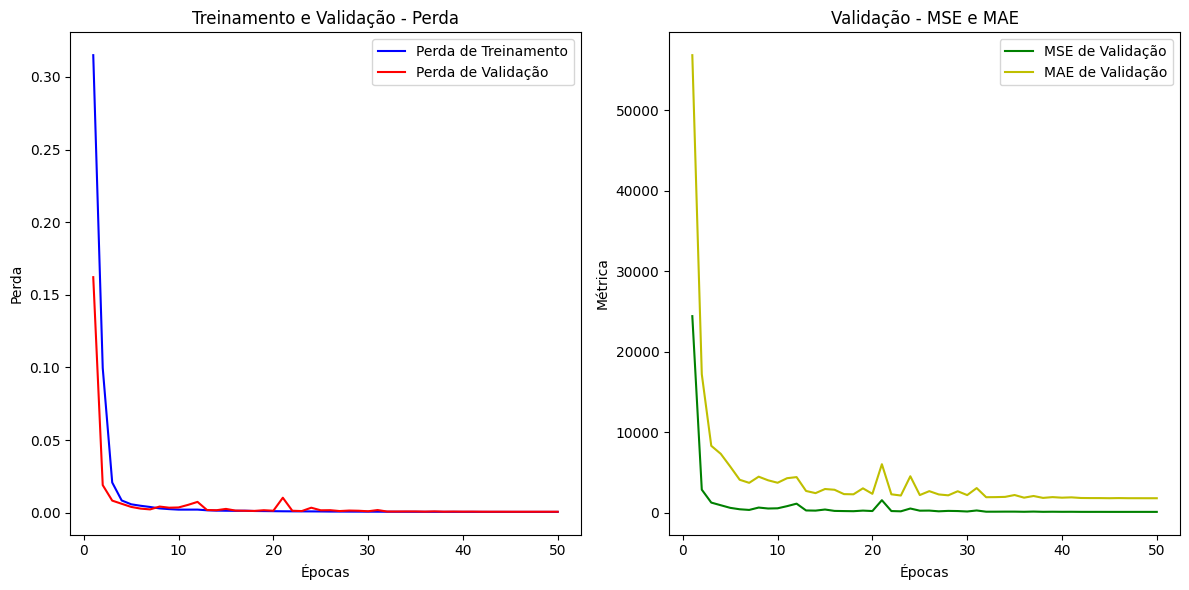

In [20]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)


# Ajustar o tamanho das listas para corresponder
min_length = min(len(epochs), len(val_mse), len(val_mae))
epochs = epochs[:min_length]
val_mse = val_mse[:min_length]
val_mae = val_mae[:min_length]

# Agora, plotar os gráficos
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b-', label='Perda de Treinamento')
plt.plot(epochs, val_losses, 'r-', label='Perda de Validação')
plt.title('Treinamento e Validação - Perda')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, val_mse, 'g-', label='MSE de Validação')
plt.plot(epochs, val_mae, 'y-', label='MAE de Validação')
plt.title('Validação - MSE e MAE')
plt.xlabel('Épocas')
plt.ylabel('Métrica')
plt.legend()

plt.tight_layout()
plt.show()


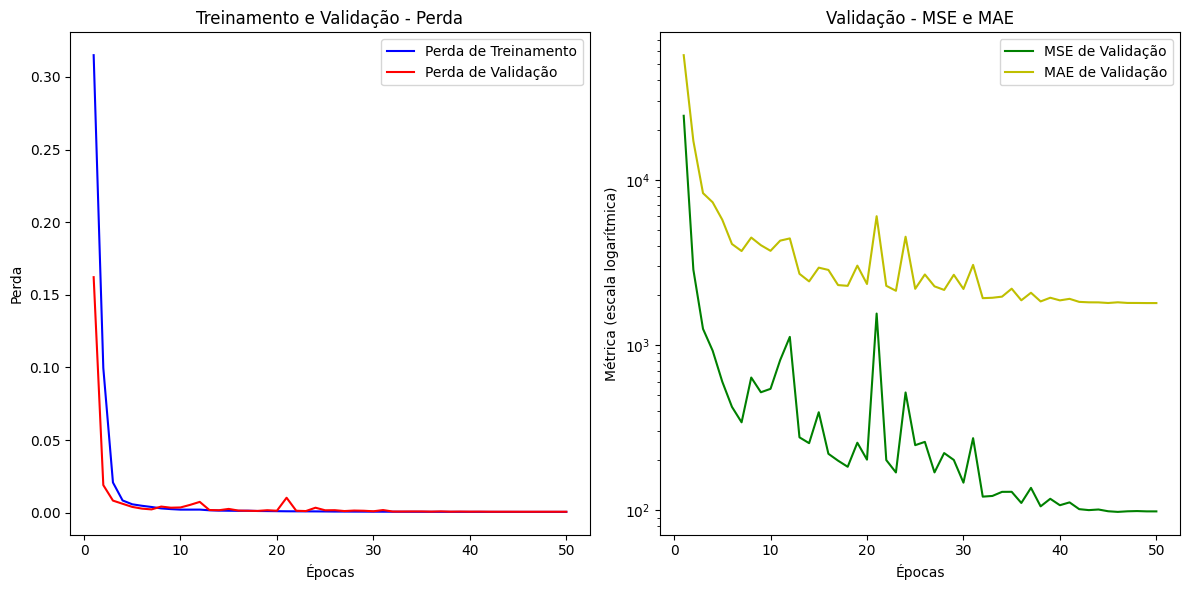

In [21]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

# Ajustar o tamanho das listas para corresponder
min_length = min(len(epochs), len(val_mse), len(val_mae))
epochs = epochs[:min_length]
val_mse = val_mse[:min_length]
val_mae = val_mae[:min_length]

# Agora, plotar os gráficos
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b-', label='Perda de Treinamento')
plt.plot(epochs, val_losses, 'r-', label='Perda de Validação')
plt.title('Treinamento e Validação - Perda')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, val_mse, 'g-', label='MSE de Validação')
plt.plot(epochs, val_mae, 'y-', label='MAE de Validação')
plt.title('Validação - MSE e MAE')
plt.xlabel('Épocas')
plt.ylabel('Métrica (escala logarítmica)')
plt.yscale('log')
plt.legend()

plt.tight_layout()
plt.show()


pred_rnn


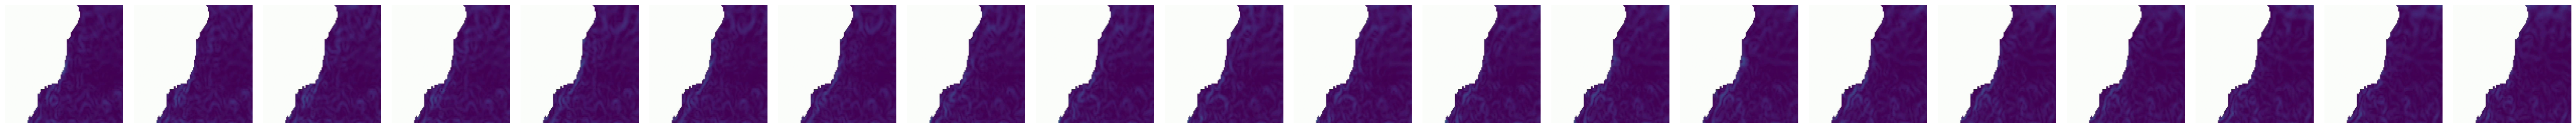

In [22]:
custom_exp = custom_training_config["ex_name"]
print(custom_exp)
inputs = np.load(f'./work_dirs/{custom_exp}/saved/inputs.npy')
preds = np.load(f'./work_dirs/{custom_exp}/saved/preds.npy')
trues = np.load(f'./work_dirs/{custom_exp}/saved/trues.npy')

example_idx = 0
show_video_line(trues[example_idx], ncols=aft_seq_length, vmax=0.6, cbar=False, out_path=None, format='png', use_rgb=True)

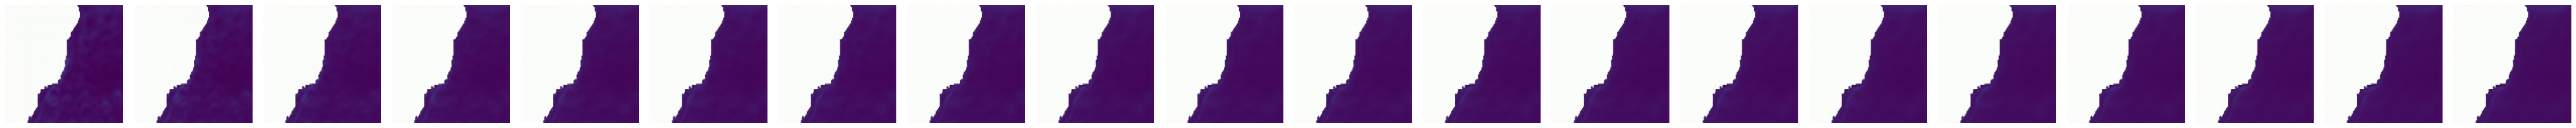

In [24]:
example_idx = 0
show_video_line(preds[example_idx], ncols=aft_seq_length, vmax=0.6, cbar=False, out_path=None, format='png', use_rgb=True)

/content/OpenSTL/openstl/utils/visualization.py:117: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 6))


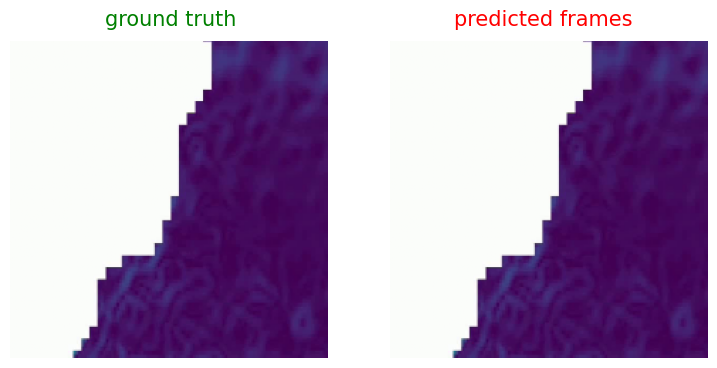

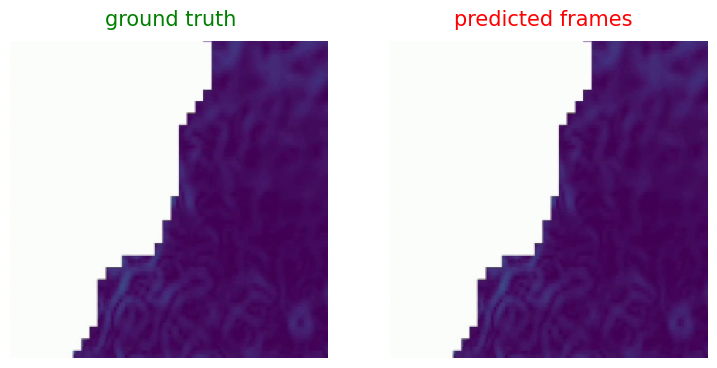

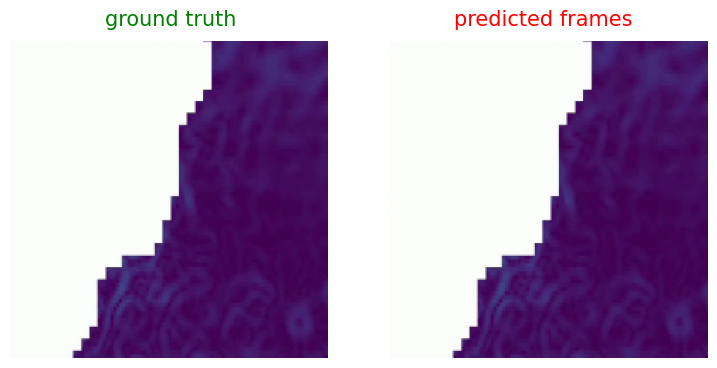

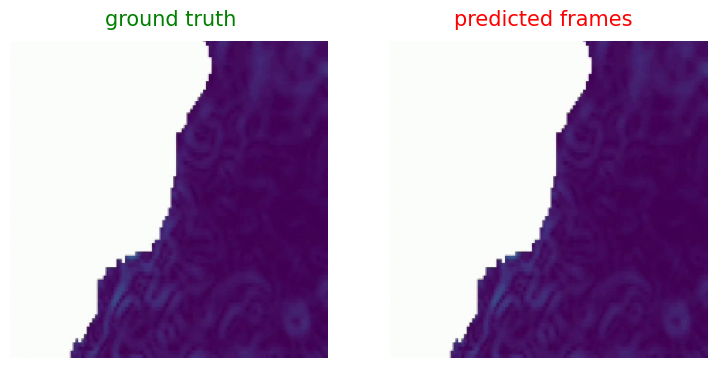

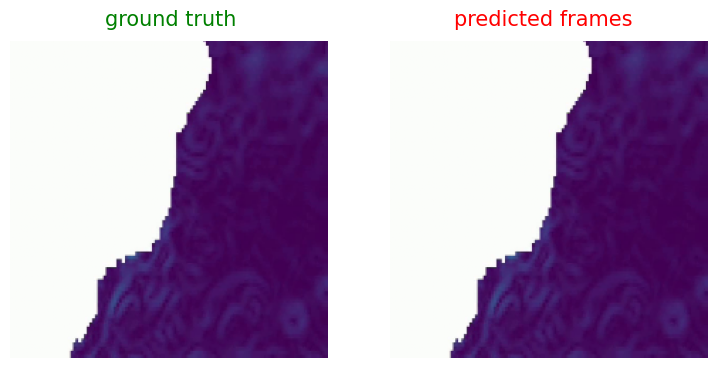

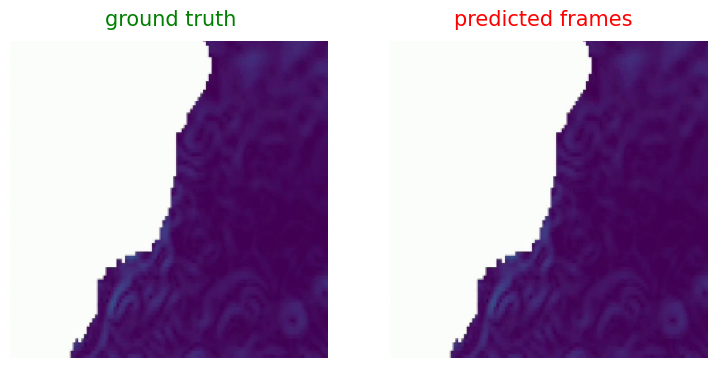

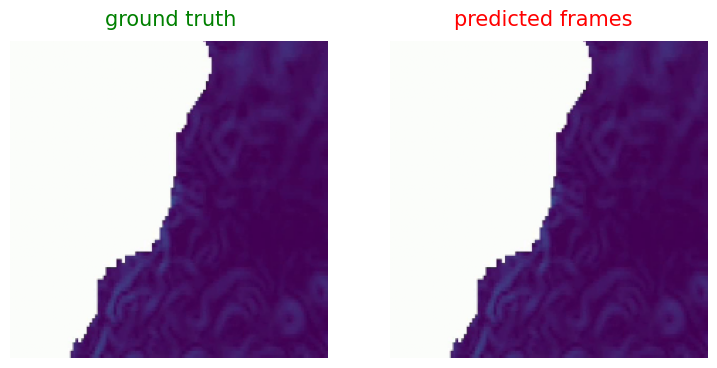

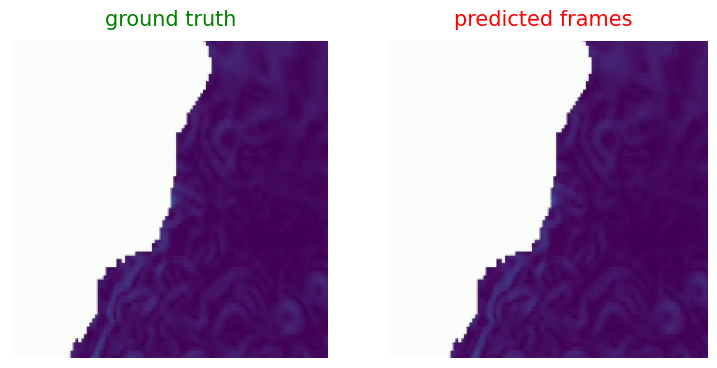

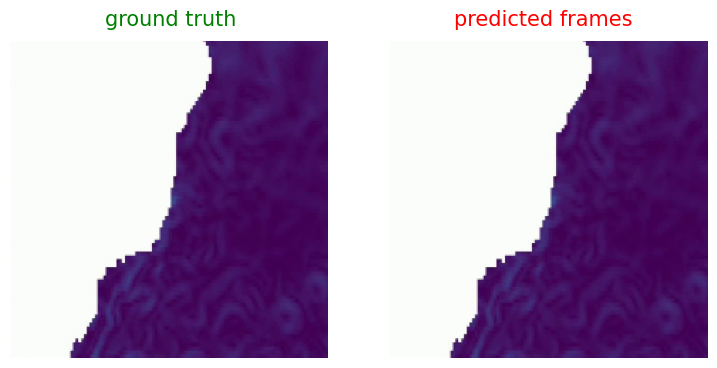

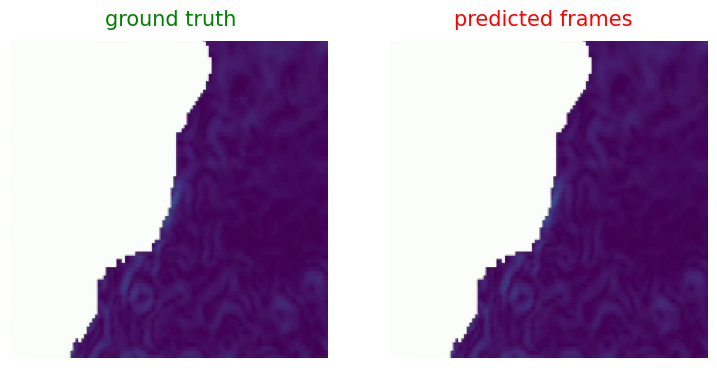

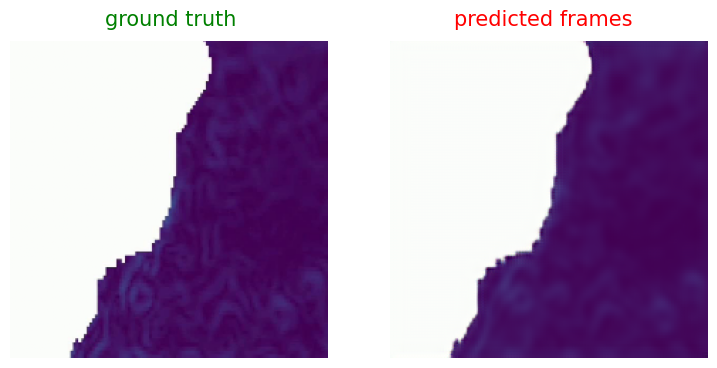

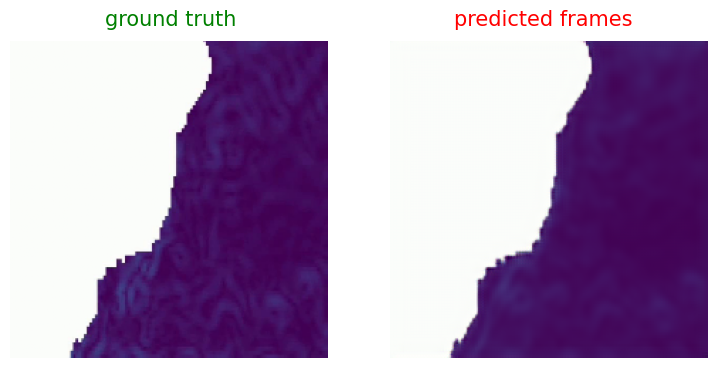

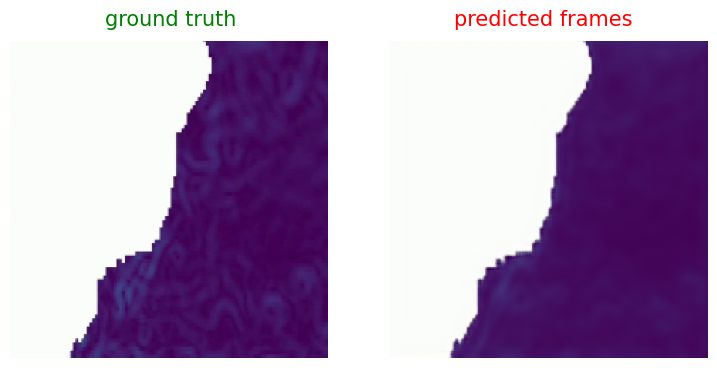

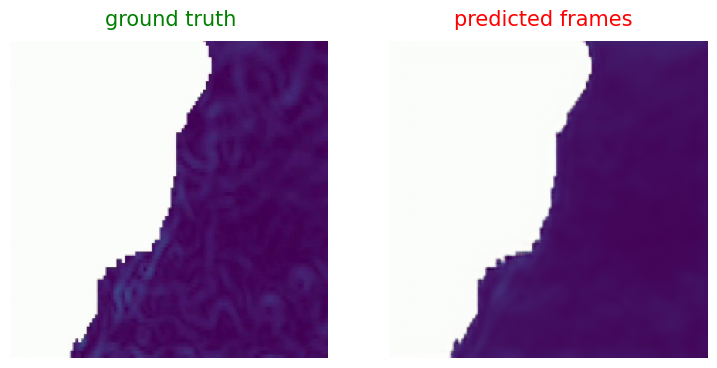

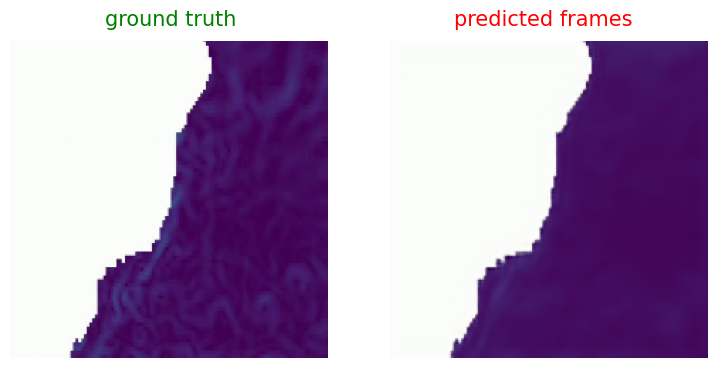

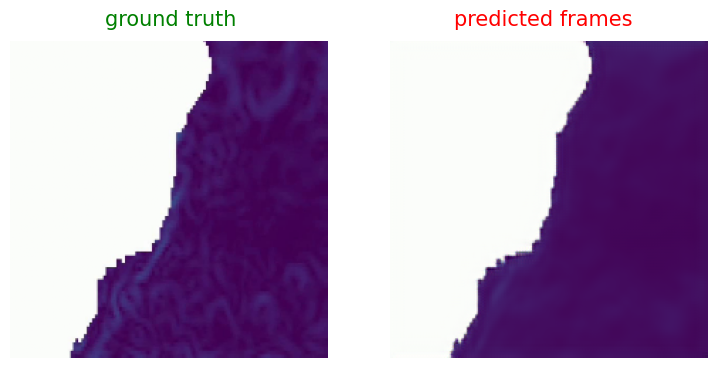

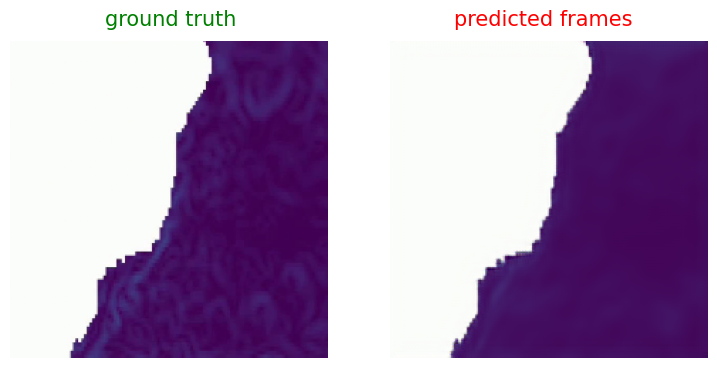

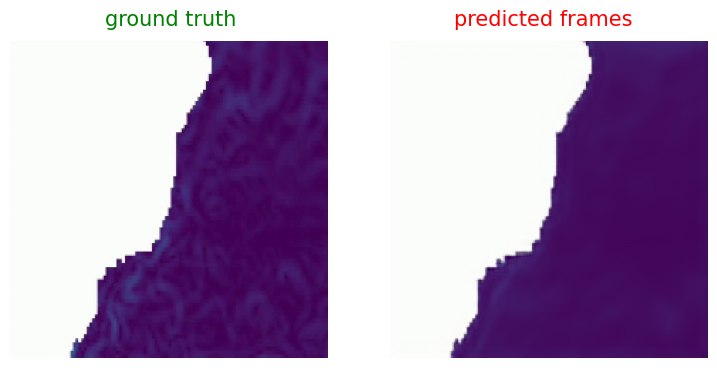

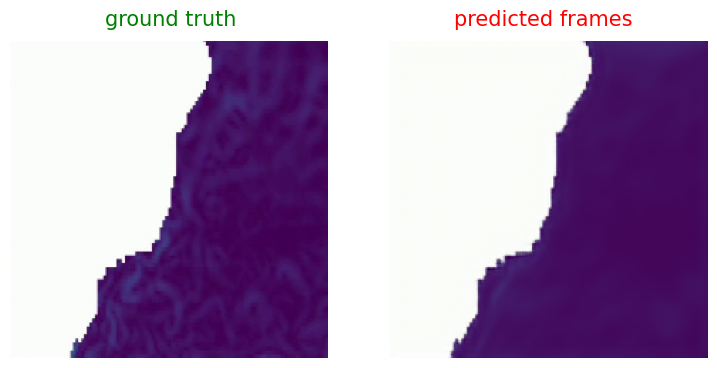

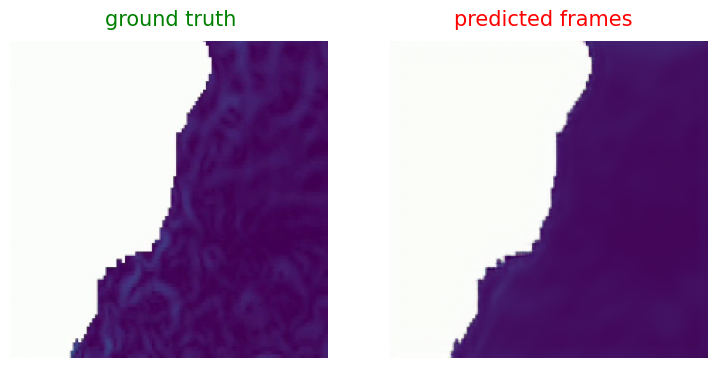

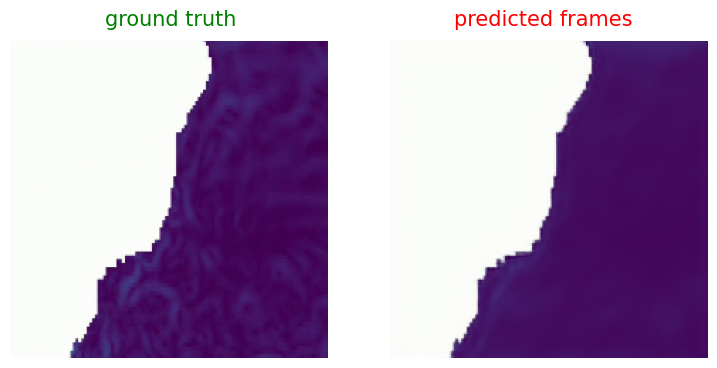

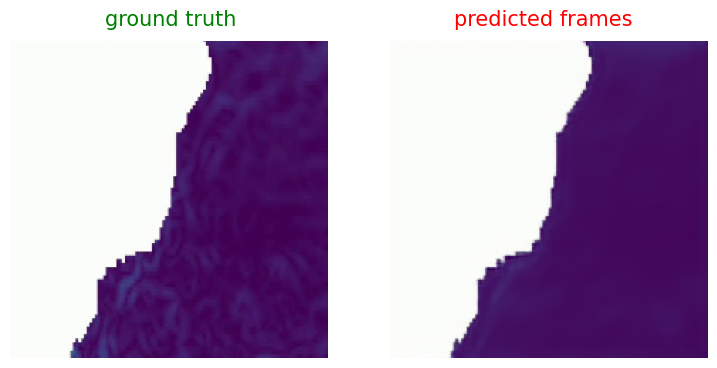

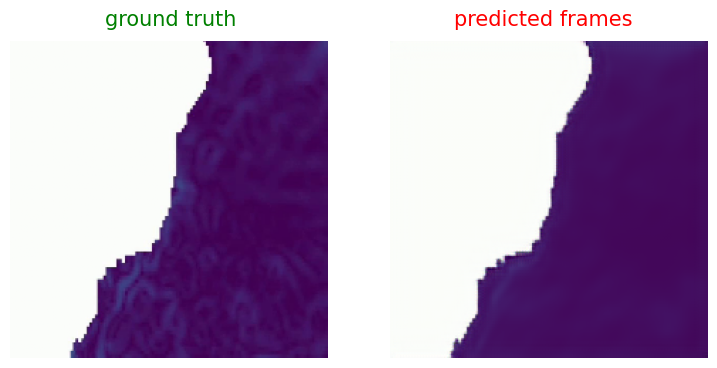

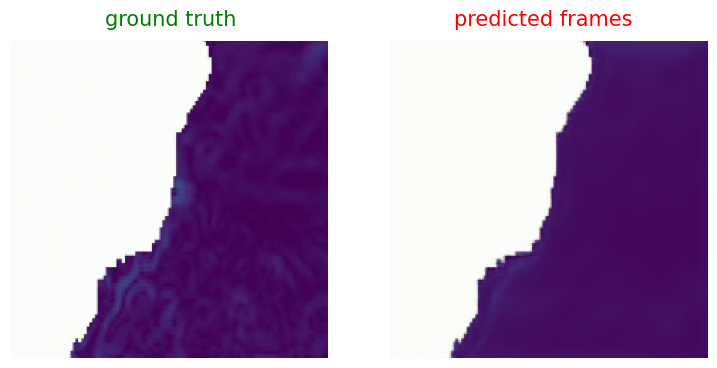

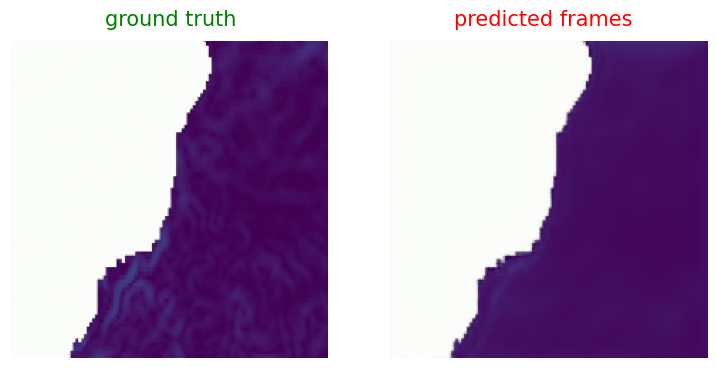

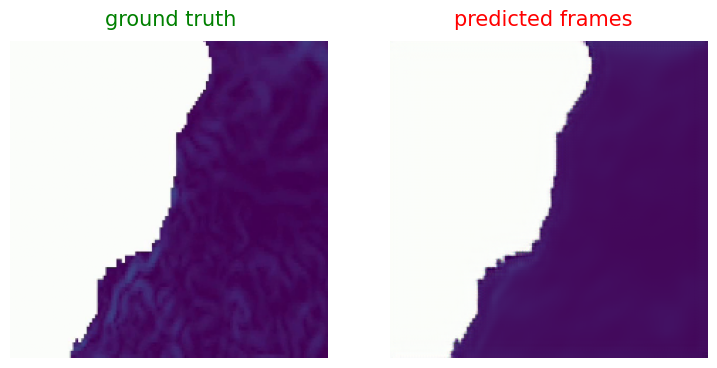

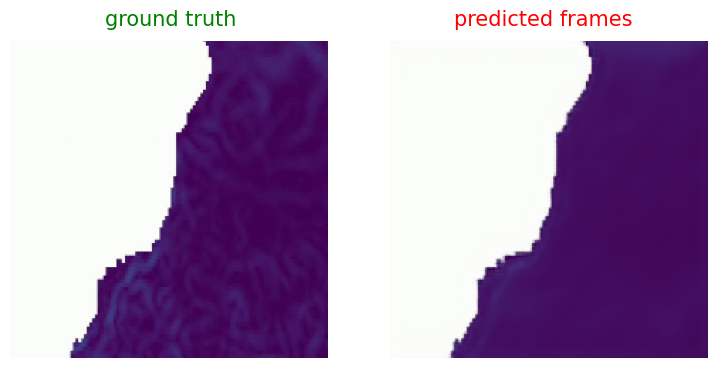

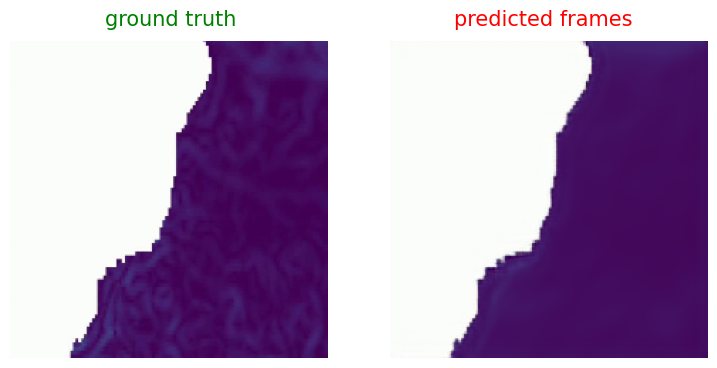

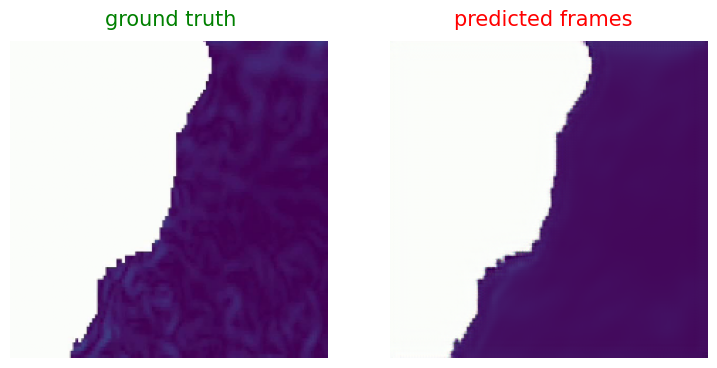

In [23]:
from openstl.utils import show_video_gif_multiple

example_idx = 0
show_video_gif_multiple(inputs[example_idx], trues[example_idx], preds[example_idx], use_rgb=True, out_path=f'{custom_exp}.gif')